In [1]:
'''
very simple CNN for MNIST 
based on
https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten , BatchNormalization

from keras.optimizers import SGD, Adam
from keras import initializers
from keras import backend as K
from sklearn import preprocessing

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
from PIL import Image
from keras.callbacks import TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
import numpy as np
from sklearn import preprocessing
movie_data = np.load('/home/ubuntu/movie_data_compressed.npz')

In [3]:
#Read the data and binarize the y value

x_train1 = movie_data['X_train']
y_traina = movie_data['y_train']
x_test1 = movie_data['X_test']
y_testa = movie_data['y_test']
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_traina))
y_train1= le.transform(y_traina)
y_test1 =le.transform(y_testa)
print(np.unique(y_train1))

[0 1 2 3 4 5 6 7]


In [4]:
# backup the files
x_train = x_train1
y_train = y_train1

x_test = x_test1
y_test = y_test1

print(x_train.shape)

(13900, 192, 128, 3)


In [5]:
#get the counts to see any imbalanced nature of data if exists
print(len(y_train[y_train == 0]))
print(len(y_train[y_train  == 1]))
print(len(y_train[y_train  == 2]))
print(len(y_train[y_train  == 3]))
print(len(y_train[y_train  == 4]))
print(len(y_train[y_train  == 5]))
print(len(y_train[y_train  == 6]))
print(len(y_train[y_train  == 7]))
print(len(y_train))

985
3160
1009
235
1062
848
6103
498
13900


### Oversample the classes 3 and 7 by 3 and 2 folds

In [6]:
#Get the indices
index_3 = [i for i in range(0,len(y_train)) if y_train[i]==3]
index_7 = [i for i in range(0,len(y_train)) if y_train[i]==7]
print(len(index_3))
print(len(index_7))

235
498


In [7]:
#Repeat the data for classes 3 and 7 to make them little imbalanced
x_train_3 = x_train1[index_3].repeat(3,axis=0)
y_train_3 = y_train1[index_3].repeat(3,axis=0)
x_train_3 = np.vstack((x_train1,x_train_3))
y_train_3=  np.hstack((y_train1,y_train_3))

x_train_7 = x_train1[index_7].repeat(1,axis=0)
y_train_7 = y_train1[index_7].repeat(1,axis=0)
x_train_final = np.vstack((x_train_3,x_train_7))
y_train_final=  np.hstack((y_train_3,y_train_7))
print(x_train_final.shape)
print(y_train_final.shape)

(15103, 192, 128, 3)
(15103,)


In [8]:
#shuffle the whole xtrain and y_train in unison
indices=np.random.permutation(len(y_train_final))
len(indices)

15103

In [9]:
x_train = x_train_final[indices]
y_train = y_train_final[indices]

print(x_train.shape)
print(y_train.shape)


(15103, 192, 128, 3)
(15103,)


In [10]:
print(len(y_train[y_train == 0]))
print(len(y_train[y_train  == 1]))
print(len(y_train[y_train  == 2]))
print(len(y_train[y_train  == 3]))
print(len(y_train[y_train  == 4]))
print(len(y_train[y_train  == 5]))
print(len(y_train[y_train  == 6]))
print(len(y_train[y_train  == 7]))
print(len(y_train))

985
3160
1009
940
1062
848
6103
996
15103


### Calculation of class weights

In [11]:

freq=np.bincount(y_train)
#labels_dict = {0: 985, 1: 3160, 2: 1009, 3: 940, 4: 1062, 5: 848, 6: 6103, 7: 996}
labels_dict = {0: freq[0], 1: freq[1], 2: freq[2], 3: freq[3], 4: freq[4], 5: freq[5], 6: freq[6], 7: freq[7]}
np.sum(labels_dict.values())

15103

In [12]:
import math
import numpy as np

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
        
    return class_weight

# random labels_dict
#labels_dict = {0: 985, 1: 3160, 2: 1009, 3: 940, 4: 1062, 5: 848, 6: 6103, 7: 996}

class_weight =create_class_weight(labels_dict)

In [13]:
num_classes = 8
# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (15103, 192, 128, 3)
15103 train samples
4634 test samples


In [14]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size =128
# number of iterations over the complete training data
epochs = 25

input_shape = (192, 128,3)

# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape,
                 kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(BatchNormalization())
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(BatchNormalization())
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
# --- fully connected layer ---
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# --- fully connected layer ---
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# --- classification ---
model.add(Dense(8, activation='softmax'))

# prints out a summary of the model architecture
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 188, 124, 16)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 188, 124, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 94, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 60, 64)        9280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 92, 60, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 88320)             0         
__________

In [15]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


In [18]:
tensorboard = TensorBoard(log_dir='./logs/cnn01/' , histogram_freq=1, write_graph=True, write_images=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=0.001)


# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    ,class_weight= class_weight
                    ,validation_split=0.2
                    #,callbacks=[tensorboard]
                   # ,callbacks=[tensorboard]
                   )

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




Train on 12082 samples, validate on 3021 samples
Epoch 1/25
12082/12082 [==============================] - 42s - loss: 1.3993 - acc: 0.4956 - val_loss: 1.6382 - val_acc: 0.4277

In [19]:
print( model.predict_classes(x_test))

4634/4634 [==============================] - 6s      

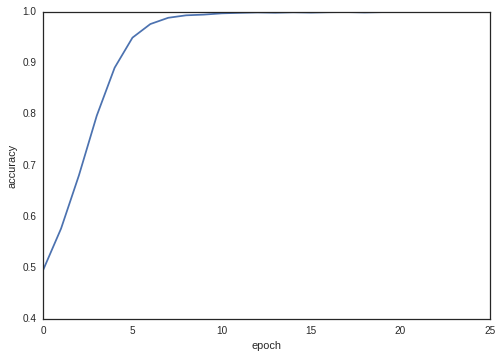

In [20]:
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")